**Assignment 2**

In [27]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [28]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [29]:
dataset = torchvision.datasets.CIFAR10(root='../1/data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

**Exercise 2.1**

In [30]:
def train_test_split(dataset, ratio):
    # Compute the number of training examples
    n_total = len(dataset)
    n_train = int(n_total * ratio)
    n_test = n_total - n_train

    # Use PyTorch's random_split to get two subsets
    training_data, testing_data = torch.utils.data.random_split(dataset, [n_train, n_test])
    
    return training_data, testing_data


**Exercise 2.2**

In [31]:
def extract_rgb_descriptors(dataset):
    """
    Extract a global RGB descriptor for each image in the dataset.
    Each descriptor is computed by concatenating 8-bin histograms for each of the 
    three channels (R, G, B), resulting in a 24-dimensional feature vector.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset where each sample is (image, label).
        
    Returns:
        np.ndarray: Array of shape (n, 24) with one descriptor per image.
    """
    descriptors = []
    
    # Loop over all samples in the dataset
    for i in range(len(dataset)):
        image, label = dataset[i]  # image is a tensor of shape (3, H, W)
        # Convert the tensor to a numpy array (shape: 3 x H x W)
        image_np = image.numpy()
        
        descriptor = []
        # Process each channel (R, G, B)
        for channel in image_np:
            # Flatten the channel to a 1D array
            flat_channel = channel.flatten()
            # Compute an 8-bin histogram over the range [-1, 1]
            hist, _ = np.histogram(flat_channel, bins=8, range=(-1, 1))
            # Append the histogram to our descriptor list
            descriptor.extend(hist.tolist())
            
        descriptors.append(descriptor)
        
    # Convert list of descriptors to a numpy array of shape (n, 24)
    return np.array(descriptors)

# Example usage:
# Assume 'train_data' and 'test_data' are obtained from your train_test_split function.
train_data, test_data = train_test_split(dataset, 0.8)
train_descriptors = extract_rgb_descriptors(train_data)
test_descriptors = extract_rgb_descriptors(test_data)

print("Train descriptors shape:", train_descriptors.shape)
print("Test descriptors shape:", test_descriptors.shape)


Train descriptors shape: (40000, 24)
Test descriptors shape: (10000, 24)


**Exercise 2.3**

In [32]:
import torch.nn as nn
from torchvision import models

# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Remove the last fully connected layer by replacing it with an identity mapping.
# This ensures that the output of the network is the feature vector right before the classifier.
model.fc = nn.Identity()

# Set the model to evaluation mode
model.eval()

def extract_cnn_descriptors(dataset, model, device='cpu'):
    """
    Extract CNN descriptors from a dataset using a pretrained model.
    
    For each image in the dataset, the function performs a forward pass through the model
    and saves the output (from the layer just before the removed fully-connected layer) as
    the image descriptor.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset from which to extract features.
        model (torch.nn.Module): The pretrained model with the last FC layer removed.
        device (str): Device to perform computations on ('cpu' or 'cuda').
        
    Returns:
        np.ndarray: An array of descriptors, one per image.
    """
    descriptors = []
    
    # Ensure model is on the correct device
    model.to(device)
    
    with torch.no_grad():
        for i in range(len(dataset)):
            image, label = dataset[i]
            # Add a batch dimension (required by the model) and move to device
            image = image.unsqueeze(0).to(device)
            
            # Forward pass to extract features
            feature = model(image)
            
            # Remove any extra dimensions and convert to a numpy array
            feature = feature.squeeze().cpu().numpy()
            descriptors.append(feature)
    
    return np.array(descriptors)

# Example usage:
# Assume 'train_data' and 'test_data' are already defined (from train_test_split)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_cnn_descriptors = extract_cnn_descriptors(train_data, model, device=device)
test_cnn_descriptors = extract_cnn_descriptors(test_data, model, device=device)

print("Train CNN descriptors shape:", train_cnn_descriptors.shape)
print("Test CNN descriptors shape:", test_cnn_descriptors.shape)


Train CNN descriptors shape: (40000, 512)
Test CNN descriptors shape: (10000, 512)


**Exercise 2.4**

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def accuracy_metric(actual, predicted):
    """
    Evaluate the accuracy of predictions and display additional metrics.
    
    Args:
        actual (list or np.array): True labels.
        predicted (list or np.array): Predicted labels.
        
    Returns:
        float: Accuracy value.
    """
    # Calculate accuracy
    accuracy_value = accuracy_score(actual, predicted)
    
    # Calculate precision, recall and F-score (weighted average in case of class imbalance)
    precision, recall, fscore, _ = precision_recall_fscore_support(
        actual, predicted, average='weighted', zero_division=0
    )
    
    # Print out the additional metrics
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F-score: {:.4f}".format(fscore))
    
    return accuracy_value

# Example usage:
# Suppose we have lists of actual and predicted labels:
actual_labels = [0, 1, 2, 1, 0, 2]
predicted_labels = [0, 2, 2, 1, 0, 1]
acc = accuracy_metric(actual_labels, predicted_labels)
print("Accuracy: {:.4f}".format(acc))


Precision: 0.6667
Recall: 0.6667
F-score: 0.6667
Accuracy: 0.6667


**Exercise 2.5**

In [34]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assuming the following variables are already defined from previous exercises:
# train_descriptors, test_descriptors (RGB features)
# train_cnn_descriptors, test_cnn_descriptors (CNN features)
# train_data, test_data (dataset splits)

# Extract labels from the dataset splits
train_labels = np.array([label for (_, label) in train_data])
test_labels = np.array([label for (_, label) in test_data])

kvalue_list = [2, 4, 6, 10, 15]

print("=== Evaluating k-NN classifier on RGB descriptors ===")
for k in kvalue_list:
    knn_rgb = KNeighborsClassifier(n_neighbors=k)
    # Fit on the training RGB descriptors
    knn_rgb.fit(train_descriptors, train_labels)
    # Predict on the testing RGB descriptors
    predictions_rgb = knn_rgb.predict(test_descriptors)
    print(f"\nRGB Descriptors with k = {k}:")
    acc_rgb = accuracy_metric(test_labels, predictions_rgb)
    print("Accuracy (RGB): {:.4f}".format(acc_rgb))

print("\n=== Evaluating k-NN classifier on CNN descriptors ===")
for k in kvalue_list:
    knn_cnn = KNeighborsClassifier(n_neighbors=k)
    # Fit on the training CNN descriptors
    knn_cnn.fit(train_cnn_descriptors, train_labels)
    # Predict on the testing CNN descriptors
    predictions_cnn = knn_cnn.predict(test_cnn_descriptors)
    print(f"\nCNN Descriptors with k = {k}:")
    acc_cnn = accuracy_metric(test_labels, predictions_cnn)
    print("Accuracy (CNN): {:.4f}".format(acc_cnn))


=== Evaluating k-NN classifier on RGB descriptors ===

RGB Descriptors with k = 2:
Precision: 0.2801
Recall: 0.2550
F-score: 0.2435
Accuracy (RGB): 0.2550

RGB Descriptors with k = 4:
Precision: 0.2975
Recall: 0.2888
F-score: 0.2837
Accuracy (RGB): 0.2888

RGB Descriptors with k = 6:
Precision: 0.3015
Recall: 0.2962
F-score: 0.2937
Accuracy (RGB): 0.2962

RGB Descriptors with k = 10:
Precision: 0.3129
Recall: 0.3102
F-score: 0.3067
Accuracy (RGB): 0.3102

RGB Descriptors with k = 15:
Precision: 0.3217
Recall: 0.3199
F-score: 0.3156
Accuracy (RGB): 0.3199

=== Evaluating k-NN classifier on CNN descriptors ===

CNN Descriptors with k = 2:
Precision: 0.5087
Recall: 0.4762
F-score: 0.4745
Accuracy (CNN): 0.4762

CNN Descriptors with k = 4:
Precision: 0.5346
Recall: 0.5308
F-score: 0.5294
Accuracy (CNN): 0.5308

CNN Descriptors with k = 6:
Precision: 0.5485
Recall: 0.5479
F-score: 0.5466
Accuracy (CNN): 0.5479

CNN Descriptors with k = 10:
Precision: 0.5614
Recall: 0.5621
F-score: 0.5601
Ac

**Exercise 2.6**

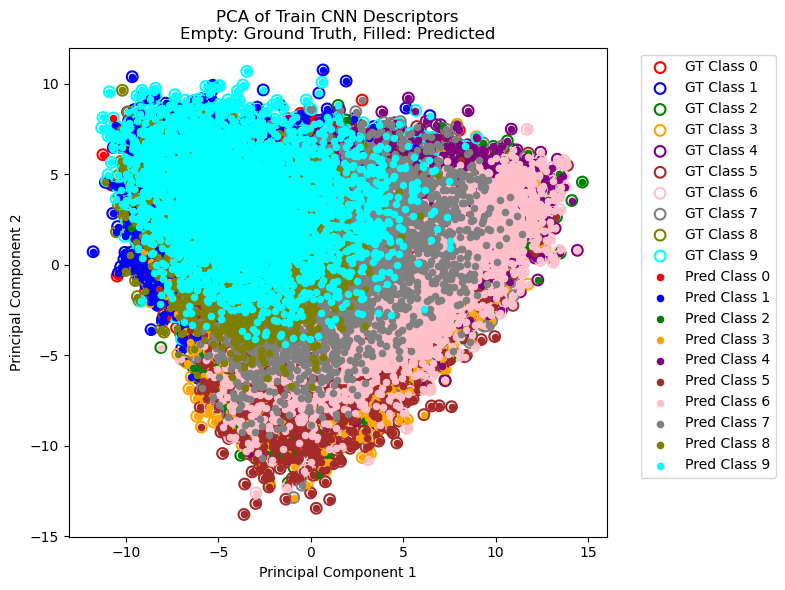

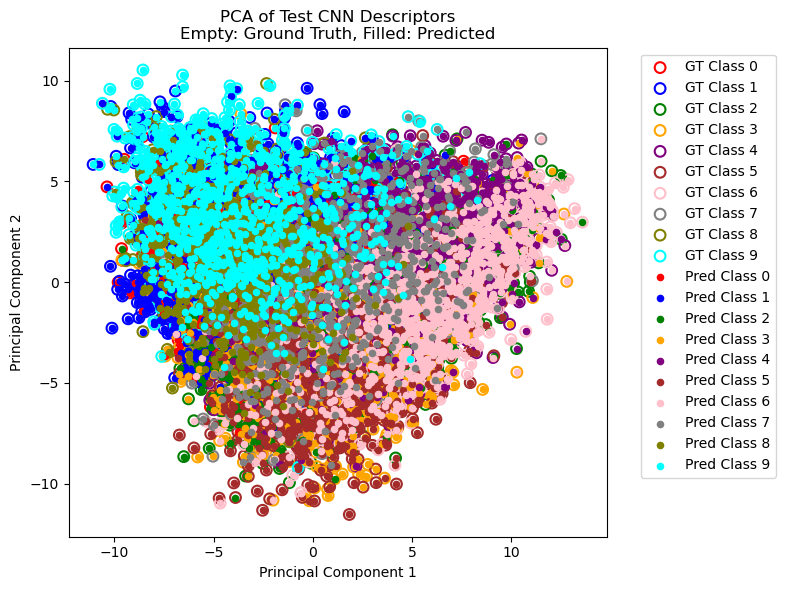

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# ----- Configuration -----
# Best k value determined from previous experiments (example: k=6)
best_k = 6

# Define colors for CIFAR-10's 10 classes
colors = ['red', 'blue', 'green', 'orange', 'purple', 
          'brown', 'pink', 'gray', 'olive', 'cyan']

# ----- Part A: Visualization on Train CNN Descriptors (Exercise 2.6a) -----

# Train a k-NN classifier on the train CNN descriptors
knn_cnn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_cnn_best.fit(train_cnn_descriptors, train_labels)

# Predict labels on the train CNN descriptor set
train_predictions = knn_cnn_best.predict(train_cnn_descriptors)

# Apply PCA on the train CNN descriptors to reduce to 2 dimensions
pca_train = PCA(n_components=2)
train_pca = pca_train.fit_transform(train_cnn_descriptors)

# Create a figure for visualization
plt.figure(figsize=(8, 6))

# Plot the ground truth labels with empty circles
for class_label in np.unique(train_labels):
    indices = np.where(train_labels == class_label)
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1],
                facecolors='none', edgecolors=colors[class_label],
                s=60, linewidths=1.5, label=f'GT Class {class_label}')

# Overlay the predicted labels with filled circles
for class_label in np.unique(train_predictions):
    indices = np.where(train_predictions == class_label)
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1],
                color=colors[class_label], marker='o',
                s=20, label=f'Pred Class {class_label}')

plt.title("PCA of Train CNN Descriptors\nEmpty: Ground Truth, Filled: Predicted")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ----- Part B: Visualization on Test CNN Descriptors (Exercise 2.6b) -----

# Predict labels on the test CNN descriptor set using the same classifier
test_predictions = knn_cnn_best.predict(test_cnn_descriptors)

# Apply PCA on the test CNN descriptors (here we apply PCA separately)
pca_test = PCA(n_components=2)
test_pca = pca_test.fit_transform(test_cnn_descriptors)

# Create a new figure for test set visualization
plt.figure(figsize=(8, 6))

# Plot ground truth for test samples with empty circles
for class_label in np.unique(test_labels):
    indices = np.where(test_labels == class_label)
    plt.scatter(test_pca[indices, 0], test_pca[indices, 1],
                facecolors='none', edgecolors=colors[class_label],
                s=60, linewidths=1.5, label=f'GT Class {class_label}')

# Overlay the predicted labels (filled circles)
for class_label in np.unique(test_predictions):
    indices = np.where(test_predictions == class_label)
    plt.scatter(test_pca[indices, 0], test_pca[indices, 1],
                color=colors[class_label], marker='o',
                s=20, label=f'Pred Class {class_label}')

plt.title("PCA of Test CNN Descriptors\nEmpty: Ground Truth, Filled: Predicted")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Exercise 2.7**

In [36]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
import numpy as np

# Assume that train_cnn_descriptors (features) and train_labels (labels) are defined from previous exercises
# For this example, we'll assume best_k was determined to be 6 in previous experiments.
best_k = 6

# List of k-fold values to test
k_list = [2, 5, 10]
avg_acc_list = []

# For each k-fold configuration, perform cross-validation
for k in k_list:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    
    # Iterate over each fold
    for train_index, val_index in kfold.split(train_cnn_descriptors):
        X_train_fold = train_cnn_descriptors[train_index]
        y_train_fold = train_labels[train_index]
        X_val_fold = train_cnn_descriptors[val_index]
        y_val_fold = train_labels[val_index]
        
        # Initialize and train the k-NN classifier using the best k value
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        predictions = knn.predict(X_val_fold)
        
        # Compute accuracy for this fold using our previously defined function
        acc = accuracy_metric(y_val_fold, predictions)
        fold_accuracies.append(acc)
    
    avg_acc_list.append(fold_accuracies)

# Display summary results
print('Summary results:\n')
for i, k in enumerate(k_list):
    print(f'{k}-fold cross validation:')
    print('Accuracies per fold:', avg_acc_list[i])
    avg_acc = round(sum(avg_acc_list[i]) / k, 2)
    std_acc = round(np.std(avg_acc_list[i]), 2)
    print(f'Average accuracy: {avg_acc} ± {std_acc}\n')


Precision: 0.5276
Recall: 0.5245
F-score: 0.5236
Precision: 0.5272
Recall: 0.5250
F-score: 0.5236
Precision: 0.5327
Recall: 0.5320
F-score: 0.5294
Precision: 0.5442
Recall: 0.5386
F-score: 0.5391
Precision: 0.5435
Recall: 0.5426
F-score: 0.5411
Precision: 0.5495
Recall: 0.5476
F-score: 0.5467
Precision: 0.5469
Recall: 0.5445
F-score: 0.5433
Precision: 0.5368
Recall: 0.5345
F-score: 0.5324
Precision: 0.5456
Recall: 0.5450
F-score: 0.5426
Precision: 0.5497
Recall: 0.5465
F-score: 0.5458
Precision: 0.5452
Recall: 0.5387
F-score: 0.5393
Precision: 0.5392
Recall: 0.5380
F-score: 0.5368
Precision: 0.5522
Recall: 0.5513
F-score: 0.5494
Precision: 0.5534
Recall: 0.5517
F-score: 0.5499
Precision: 0.5451
Recall: 0.5430
F-score: 0.5424
Precision: 0.5588
Recall: 0.5573
F-score: 0.5557
Precision: 0.5421
Recall: 0.5393
F-score: 0.5382
Summary results:

2-fold cross validation:
Accuracies per fold: [0.52455, 0.525]
Average accuracy: 0.52 ± 0.0

5-fold cross validation:
Accuracies per fold: [0.532, 0.